In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold

from imblearn.combine import SMOTETomek, SMOTEENN

from xgboost import XGBClassifier


In [9]:
train_raw = pd.read_csv("data/train.csv")


In [10]:
train_raw = train_raw.drop(columns=['SNo'])
train, eval = train_test_split(train_raw.sort_values(by='time'), train_size=0.8, shuffle=False)

print(train.shape)
print(train['Label'].value_counts())
print(eval.shape)
print(eval['Label'].value_counts())

(35808, 20)
Label
0    28360
2     6123
1     1325
Name: count, dtype: int64
(8952, 20)
Label
0    6819
2    1633
1     500
Name: count, dtype: int64


In [11]:
def time_split(df):
    df['year'] = df['time'].astype(str).str[0:4].astype(int)
    df['month'] = df['time'].astype(str).str[4:6].astype(int)
    df = df.drop(columns=['time'])
    return df

    
def data_preprocessing_1(df, sampling_technique=None, features_to_apply=[]):

    feature_names = [x for x in df.columns if x != 'Label']

    print(f'Labels before subsampling')
    print(df['Label'].value_counts())

    if sampling_technique == 'remove_dups':
        sampled_df = df.groupby(feature_names, as_index=False).agg({'Label': lambda x:stats.mode(x)[0]}).copy().reset_index(drop=True)
        X_df = sampled_df[feature_names]
        y_df = sampled_df['Label']

    elif sampling_technique == 'SMOTE-TOMEK':
        smo_tek = SMOTETomek(random_state=0)
        X_df, y_df = smo_tek.fit_resample(df.drop(columns=['Label']), df['Label'])

    elif sampling_technique == 'SMOTE-ENN':
        smo_een = SMOTEENN(random_state=0)
        X_df, y_df = smo_een.fit_resample(df.drop(columns=['Label']), df['Label'])
    else:
        print('invalid/no sampling technique specified')
        X_df = df[feature_names]
        y_df = df['Label']
    
    print(f'Labels after subsampling')
    print(y_df.value_counts())

    X_df = feature_eng_x(X_df, features_to_apply)

    return X_df, y_df

def feature_eng_x(X_df, features_to_apply):
    if 'time_split' in features_to_apply:
        X_df = time_split(X_df)
    
    """ Features using m/s units"""
    if 'diff_U850_vs_V850' in features_to_apply:
        X_df['diff_U850_vs_V850'] = X_df['U850'] - X_df['V850']
    
    if 'diff_U850_vs_UBOT' in features_to_apply:
        X_df['diff_U850_vs_UBOT'] = X_df['U850'] - X_df['UBOT']
    
    if 'diff_U850_vs_VBOT' in features_to_apply:
        X_df['diff_U850_vs_VBOT'] = X_df['U850'] - X_df['VBOT']
    
    if 'diff_V850_vs_UBOT' in features_to_apply:
        X_df['diff_V850_vs_UBOT'] = X_df['V850'] - X_df['UBOT']
    
    if 'diff_V850_vs_VBOT' in features_to_apply:
        X_df['diff_V850_vs_VBOT'] = X_df['V850'] - X_df['VBOT']
    
    if 'diff_UBOT_vs_VBOT' in features_to_apply:
        X_df['diff_UBOT_vs_VBOT'] = X_df['UBOT'] - X_df['VBOT']
    
    """ Features using Pa units"""
    if  'diff_PS_vs_PSL' in features_to_apply:
        X_df['diff_PS_vs_PSL'] = X_df['PS'] - X_df['PSL']
    
    """ Features using K units"""
    if  'diff_T200_vs_T500' in features_to_apply:
        X_df['diff_T200_vs_T500'] = X_df['T200'] - X_df['T500']

    if  'diff_T200_vs_TS' in features_to_apply:
        X_df['diff_T200_vs_TS'] = X_df['T200'] - X_df['TS']
    
    if 'diff_T200_vs_TREFHT' in features_to_apply:
        X_df['diff_T200_vs_TREFHT'] = X_df['T200'] - X_df['TREFHT']
    
    if 'diff_T500_vs_TS' in features_to_apply:
        X_df['diff_T500_vs_TS'] = X_df['T500'] - X_df['TS']
    
    if 'diff_TS_vs_TREFHT' in features_to_apply:
        X_df['diff_TS_vs_TREFHT'] = X_df['TS'] - X_df['TREFHT']

    """ Features using m units"""
    if 'diff_Z1000_vs_Z200' in features_to_apply:
        X_df['diff_Z1000_vs_Z200'] = X_df['Z1000'] - X_df['Z200']
    
    if 'diff_Z1000_vs_ZBOT' in features_to_apply:
        X_df['diff_Z1000_vs_ZBOT'] = X_df['Z1000'] - X_df['ZBOT']
    
    if 'diff_Z200_vs_ZBOT' in features_to_apply:
        X_df['diff_Z200_vs_ZBOT'] = X_df['Z200'] - X_df['ZBOT']

    return X_df
    

In [12]:
features_to_apply = ['time_split',
                     'diff_U850_vs_V850',
                     'diff_U850_vs_UBOT',
                     'diff_U850_vs_VBOT',
                     'diff_V850_vs_UBOT',
                     'diff_V850_vs_VBOT',
                     'diff_UBOT_vs_VBOT',
                     'diff_PS_vs_PSL',
                     'diff_T200_vs_T500',
                     'diff_T200_vs_TS',
                     'diff_T200_vs_TREFHT',
                     'diff_T500_vs_TS',
                     'diff_TS_vs_TREFHT',
                     'diff_Z1000_vs_Z200',
                     'diff_Z1000_vs_ZBOT',
                     'diff_Z200_vs_ZBOT']

# print('-----BASELINE-----')
# X_baseline, y_baseline = data_preprocessing_1(train, sampling_technique=None, features_to_apply=features_to_apply)
print('\n-----NO DUPLICATES-----')
X_nodups, y_nodups = data_preprocessing_1(train, sampling_technique='remove_dups', features_to_apply=features_to_apply)
# print('\n-----SMOTE-TOMEK-----')
# X_smo_tomek, y_smo_tomek = data_preprocessing_1(train, sampling_technique='SMOTE-TOMEK', features_to_apply=features_to_apply)
# print('\n-----SMOTE-ENN-----')
# X_smo_enn, y_smo_enn = data_preprocessing_1(train, sampling_technique='SMOTE-ENN', features_to_apply=features_to_apply)


y_eval = eval['Label']
X_eval = eval.drop(columns=['Label'])
X_eval = feature_eng_x(X_eval, features_to_apply)



-----NO DUPLICATES-----
Labels before subsampling
Label
0    28360
2     6123
1     1325
Name: count, dtype: int64
Labels after subsampling
Label
0    12718
2     2091
1      479
Name: count, dtype: int64


In [14]:
print('-----NO DUPLICATES-----')
xgb_nodups = XGBClassifier()
xgb_nodups.fit(X_nodups, y_nodups)
xgb_nodups_preds = xgb_nodups.predict(X_eval)
print(classification_report(y_eval, xgb_nodups_preds, digits=4)) 

-----NO DUPLICATES-----
              precision    recall  f1-score   support

           0     0.8349    0.9280    0.8790      6819
           1     0.5320    0.4660    0.4968       500
           2     0.6652    0.3809    0.4844      1633

    accuracy                         0.8024      8952
   macro avg     0.6774    0.5916    0.6201      8952
weighted avg     0.7871    0.8024    0.7857      8952



# Feature Importance

Next we will take a look at feature importance to see if we can create a more generalizable model by dropping the least important features

In [16]:
importances = pd.DataFrame({
    'Feature': X_nodups.columns,
    'Importance': xgb_nodups.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
importances = importances.set_index('Feature')
importances

,Importance
Feature,
lat,0.220786
U850,0.074524
PSL,0.067737
PS,0.047136
diff_Z1000_vs_ZBOT,0.029896
lon,0.028492
diff_T500_vs_TS,0.028316
T200,0.027927
month,0.027389


In [17]:
feat_lst = importances.index.tolist()

In [18]:
feat_lst[-2:]

['PRECT', 'diff_PS_vs_PSL']

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

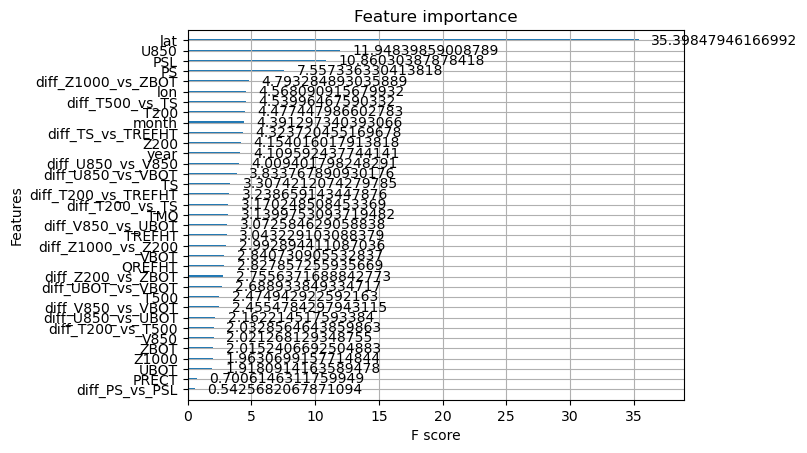

In [20]:
from xgboost import plot_importance
plot_importance(xgb_nodups, importance_type='gain')

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


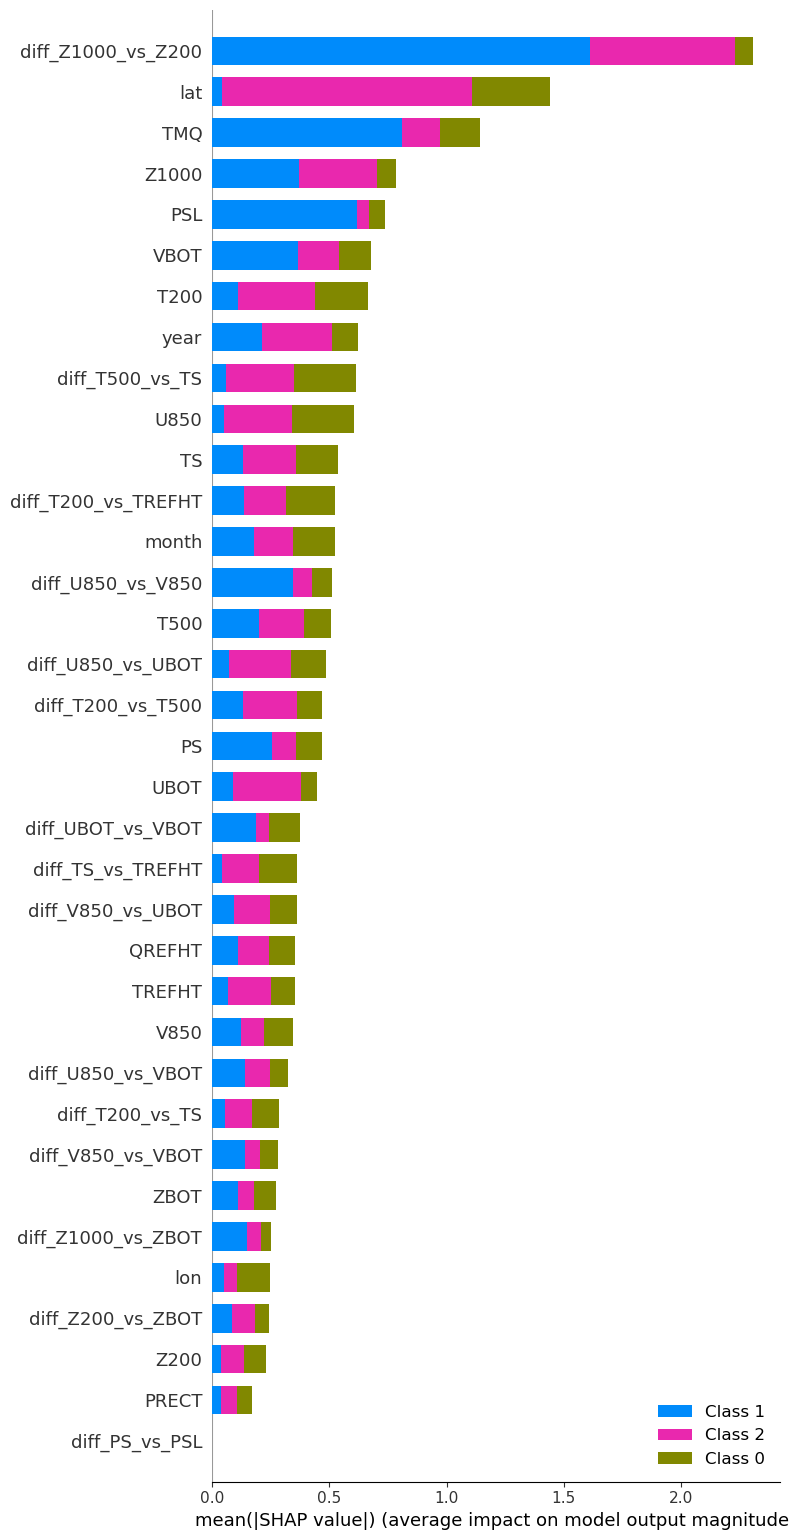

In [21]:
import shap

shap_values = shap.TreeExplainer(xgb_nodups).shap_values(X_nodups)
shap.summary_plot(shap_values, X_nodups, plot_type="bar", max_display=40)

We seem to have quite a few columns with very low importance. We will try dropping some and see if this improves performance

In [34]:
def evaluate_and_drop(feat_lst, num_features_to_drop, X_train, y_train, X_eval, y_eval, imp_plt=False):
    print(f'-----Nodups - Dropping {num_features_to_drop} least important features -----')
    print(f'dropping {feat_lst[-num_features_to_drop:]}')

    clf = XGBClassifier()
    clf.fit(X_train.drop(columns=feat_lst[-num_features_to_drop:]), y_train)
    xgb_preds = clf.predict(X_eval.drop(columns=feat_lst[-num_features_to_drop:]))
    print(classification_report(y_eval, xgb_preds, digits=4)) 
    acc = accuracy_score(y_eval, xgb_preds)
    print(f'Accuracy: {acc}')

    if imp_plt:
        plot_importance(clf, importance_type='gain')

    return acc

In [38]:
accs = [0.8024]
for x in range(1, 21):
    acc = evaluate_and_drop(feat_lst, x, X_nodups, y_nodups, X_eval, y_eval)
    accs.append(acc)

-----Nodups - Dropping 1 least important features -----
dropping ['diff_PS_vs_PSL']
              precision    recall  f1-score   support

           0     0.8308    0.9318    0.8784      6819
           1     0.5372    0.4620    0.4968       500
           2     0.6625    0.3546    0.4619      1633

    accuracy                         0.8003      8952
   macro avg     0.6768    0.5828    0.6124      8952
weighted avg     0.7837    0.8003    0.7811      8952

Accuracy: 0.8002680965147453
-----Nodups - Dropping 2 least important features -----
dropping ['PRECT', 'diff_PS_vs_PSL']
              precision    recall  f1-score   support

           0     0.8326    0.9141    0.8714      6819
           1     0.5010    0.4840    0.4924       500
           2     0.6216    0.3742    0.4671      1633

    accuracy                         0.7916      8952
   macro avg     0.6517    0.5907    0.6103      8952
weighted avg     0.7756    0.7916    0.7765      8952

Accuracy: 0.7915549597855228
---

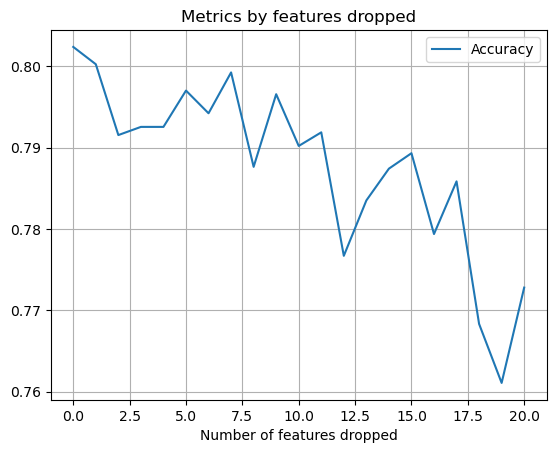

In [46]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot([x for x in range(0, 21)], accs, label='Accuracy')
plt.legend()
plt.title('Metrics by features dropped')
plt.xlabel('Number of features dropped')
plt.grid()
plt.show()

While the above chart shows that we achieve best accuracy by dropping no features, we will go with our second best result of 7 features dropped to prevent overfitting

In [47]:
features_to_drop =  ['diff_T200_vs_T500', 'V850', 'ZBOT', 'Z1000', 'UBOT', 'PRECT', 'diff_PS_vs_PSL']
X_train_dropped_feats = X_nodups.drop(columns=features_to_drop)
X_eval_dropped_feats = X_eval.drop(columns=features_to_drop)

In [48]:
xgb_smo_enn_hyperparam = XGBClassifier(eta=0.3,
                                       n_estimators=150)
xgb_smo_enn_hyperparam.fit(X_train_dropped_feats, 
                            y_nodups,
                            eval_metric='merror',
                            eval_set=[(X_eval_dropped_feats, y_eval)],
                            early_stopping_rounds=50, )
xgb_smo_enn_hyperparam_preds = xgb_smo_enn_hyperparam.predict(X_eval_dropped_feats)
print(classification_report(y_eval, xgb_smo_enn_hyperparam_preds, digits=4)) 
print(f'Accuracy: {accuracy_score(y_eval, xgb_smo_enn_hyperparam_preds)}')

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[0]	validation_0-merror:0.23581
[1]	validation_0-merror:0.21626
[2]	validation_0-merror:0.21046
[3]	validation_0-merror:0.21057
[4]	validation_0-merror:0.21805
[5]	validation_0-merror:0.21649
[6]	validation_0-merror:0.21504
[7]	validation_0-merror:0.21571
[8]	validation_0-merror:0.21291
[9]	validation_0-merror:0.21258
[10]	validation_0-merror:0.21213
[11]	validation_0-merror:0.21258
[12]	validation_0-merror:0.21291
[13]	validation_0-merror:0.21146
[14]	validation_0-merror:0.21068
[15]	validation_0-merror:0.21381
[16]	validation_0-merror:0.21470
[17]	validation_0-merror:0.21772
[18]	validation_0-merror:0.21973
[19]	validation_0-merror:0.21325
[20]	validation_0-merror:0.21079
[21]	validation_0-merror:0.20699
[22]	validation_0-merror:0.20878
[23]	validation_0-merror:0.20677
[24]	validation_0-merror:0.20621
[25]	validation_0-merror:0.20710
[26]	validation_0-merror:0.20454
[27]	validation_0-merror:0.20297
[28]	validation_0-merror:0.19962
[29]	validation_0-merror:0.19783
[30]	validation_0-me

In [84]:
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline

pipeline = Pipeline(steps=[
    ("XGBClassifier", XGBClassifier(random_state=10, 
                                    verbosity=1,
                                    ))
])
parameters = {
    "XGBClassifier__n_estimators": [350],
    "XGBClassifier__learning_rate": [0.1],
    # # Grid Search 1
    "XGBClassifier__max_depth": [6],
    "XGBClassifier__min_child_weight": [2],
    # # # Grid Search 2
    'XGBClassifier__gamma': [0.0],
    # # Grid Search 3
    'XGBClassifier__subsample': [0.3],
    'XGBClassifier__colsample_bytree': [0.6],
    # # Grid Search 4
    'XGBClassifier__reg_alpha':[0.0],
    }

clf = GridSearchCV(pipeline, 
                   scoring='accuracy',
                   param_grid=parameters,
                   verbose=1, 
                   cv=5, 
                   n_jobs=-1)

clf.fit(X_train_dropped_feats, y_nodups)

print(clf.best_params_)
print(clf.best_score_)

best_model = clf.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


{'XGBClassifier__colsample_bytree': 0.6, 'XGBClassifier__gamma': 0.0, 'XGBClassifier__learning_rate': 0.1, 'XGBClassifier__max_depth': 6, 'XGBClassifier__min_child_weight': 2, 'XGBClassifier__n_estimators': 350, 'XGBClassifier__subsample': 0.3}
0.665325888989941


In [86]:
print(classification_report(y_eval, best_model.predict(X_eval_dropped_feats), digits=4))

              precision    recall  f1-score   support

           0     0.8299    0.9289    0.8766      6819
           1     0.5000    0.4700    0.4845       500
           2     0.6706    0.3491    0.4591      1633

    accuracy                         0.7975      8952
   macro avg     0.6668    0.5826    0.6068      8952
weighted avg     0.7824    0.7975    0.7786      8952



# Predict on Test

Train model on all training data using our best hyperparameters

In [61]:
test = pd.read_csv("data/test.csv")

test = test.drop(columns=['SNo'])

features_to_apply = ['time_split',
                     'diff_U850_vs_V850',
                     'diff_U850_vs_UBOT',
                     'diff_U850_vs_VBOT',
                     'diff_V850_vs_UBOT',
                     'diff_V850_vs_VBOT',
                     'diff_UBOT_vs_VBOT',
                     'diff_PS_vs_PSL',
                     'diff_T200_vs_T500',
                     'diff_T200_vs_TS',
                     'diff_T200_vs_TREFHT',
                     'diff_T500_vs_TS',
                     'diff_TS_vs_TREFHT',
                     'diff_Z1000_vs_Z200',
                     'diff_Z1000_vs_ZBOT',
                     'diff_Z200_vs_ZBOT']



features_to_drop = ['diff_T200_vs_T500', 'V850', 'ZBOT', 'Z1000', 'UBOT', 'PRECT', 'diff_PS_vs_PSL']
test = feature_eng_x(test, features_to_apply)
test = test.drop(columns=features_to_drop)

In [67]:
test

,lat,lon,TMQ,U850,VBOT,QREFHT,PS,PSL,T200,T500,...,diff_V850_vs_UBOT,diff_V850_vs_VBOT,diff_UBOT_vs_VBOT,diff_T200_vs_TS,diff_T200_vs_TREFHT,diff_T500_vs_TS,diff_TS_vs_TREFHT,diff_Z1000_vs_Z200,diff_Z1000_vs_ZBOT,diff_Z200_vs_ZBOT
0,-30.391134,354.3750,25.907482,6.662070,-3.936030,0.010624,101532.5391,101532.5391,213.092209,256.032043,...,-10.077793,-13.574417,-3.496624,-77.605423,-76.947739,-34.665588,0.657684,-11818.874164,66.062042,11884.936206
1,-30.391134,354.3750,25.907482,6.662070,-3.936030,0.010624,101532.5391,101532.5391,213.092209,256.032043,...,-10.077793,-13.574417,-3.496624,-77.605423,-76.947739,-34.665588,0.657684,-11818.874164,66.062042,11884.936206
2,-31.095176,354.3750,27.019733,4.951319,-3.150316,0.010890,101513.0234,101513.0234,213.161011,255.616837,...,-10.054632,-14.190947,-4.136315,-77.211639,-76.779602,-34.755814,0.432037,-11802.862592,64.450840,11867.313432
3,-31.095176,354.3750,27.019733,4.951319,-3.150316,0.010890,101513.0234,101513.0234,213.161011,255.616837,...,-10.054632,-14.190947,-4.136315,-77.211639,-76.779602,-34.755814,0.432037,-11802.862592,64.450840,11867.313432
4,-30.860495,354.3750,26.516499,5.362008,-2.907396,0.010821,101505.1484,101505.1484,213.188248,255.498810,...,-9.970876,-14.320526,-4.349651,-77.509384,-76.853104,-35.198822,0.656281,-11808.572853,63.791088,11872.363941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10315,24.054759,277.1875,57.411018,3.704696,14.131296,0.020041,100295.9375,100295.9375,222.533188,267.842407,...,26.722508,3.867392,-22.855117,-78.641037,-77.951950,-33.331818,0.689087,-12330.540667,0.000000,12330.540667
10316,24.054759,276.8750,57.277252,5.944778,15.523009,0.020222,100210.2891,100210.2891,221.928162,268.028778,...,26.853539,2.906188,-23.947351,-79.457031,-78.613678,-33.356415,0.843353,-12329.038773,0.000000,12329.038773
10317,24.054759,276.8750,57.277252,5.944778,15.523009,0.020222,100210.2891,100210.2891,221.928162,268.028778,...,26.853539,2.906188,-23.947351,-79.457031,-78.613678,-33.356415,0.843353,-12329.038773,0.000000,12329.038773
10318,24.054759,276.5625,54.855862,8.170049,16.326492,0.020324,100116.5234,100116.5234,220.904862,267.992645,...,25.956468,2.838570,-23.117898,-80.503738,-79.586471,-33.415955,0.917267,-12325.338124,0.000000,12325.338124


In [68]:
features_to_drop = ['diff_T200_vs_T500', 'V850', 'ZBOT', 'Z1000', 'UBOT', 'PRECT', 'diff_PS_vs_PSL']
X_all_train, y_all_train = data_preprocessing_1(train_raw, sampling_technique='remove_dups', features_to_apply=features_to_apply)


xgb_all_train = XGBClassifier(n_estimators=350, 
                              learning_rate=0.1, 
                              max_depth=6, 
                              min_child_weight=2, 
                              gamma=0.0,
                              subsample=0.3, 
                              colsample_bytree=0.6, 
                            )


xgb_all_train.fit(X_all_train.drop(columns=features_to_drop), y_all_train)

Labels before subsampling
Label
0    35179
2     7756
1     1825
Name: count, dtype: int64


Labels after subsampling
Label
0    17488
2     2929
1      703
Name: count, dtype: int64


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              n_estimators=350, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [69]:
test_preds = xgb_all_train.predict(test)

In [70]:
np.unique(test_preds, return_counts=True)

(array([0, 1, 2], dtype=int64), array([8743,  393, 1184], dtype=int64))

In [46]:
np.savetxt("data/xgboost_enn_nodups_data.csv", np.dstack((np.arange(1, test_preds.size+1),test_preds))[0],"%d,%d",header="SNo,Labels", comments='')